# Lecture 6 - Demo Notebook

ASSISTments is a free tool for assigning and assessing math problems and homework. Teachers can select and assign problem sets. Once they get an assignment, students can complete it at their own pace and with the help of hints, multiple chances, and immediate feedback. Teachers get instant results broken down by individual student or for the whole class. The dataset involves 4,217 middle-school students practicing an electronic tutor that teaches and evaluates students in grade-school math, with a total of 525,534 trials. The student data are in a comma-delimited text file with one row per trial. The columns should correspond to a trial's user id, the order id (timestamp), the skill name, and and whether the student produced a correct response in the trial. More information on the platform can be found [here](https://www.commonsense.org/education/website/assistments). 

The ASSISTments data sets are often used for benchmarking knowledge tracing models. We will play with a simplified data set that contains the following columns:

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| skill_name | The name of the skill associated with the problem. | |
| correct | The student's performance on the problem: 1 if the problem's answer is correct at the first attempt, 0 otherwise. 

We first load the data set.

In [10]:
# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import root_mean_squared_error, mean_squared_error, roc_auc_score

# PyBKT package imports
import random
old_randint = random.randint
random.randint = lambda a, b: old_randint(a, int(b))
from pyBKT.models import Model
random.randint = old_randint

DATA_DIR = "./../../data/"

In [2]:
assistments = pd.read_csv(DATA_DIR + 'assistments.csv', low_memory=False).dropna()
assistments.head()

,user_id,order_id,skill_name,correct
0,64525,33022537,Box and Whisker,1
1,64525,33022709,Box and Whisker,1
2,70363,35450204,Box and Whisker,0
3,70363,35450295,Box and Whisker,1
4,70363,35450311,Box and Whisker,0


Next, we print the number of unique students and skills in this data set.

In [3]:
print("Number of unique students in the dataset:", len(set(assistments['user_id'])))
print("Number of unique skills in the dataset:", len(set(assistments['skill_name'])))

Number of unique students in the dataset: 4151
Number of unique skills in the dataset: 110


To keep things simpler for demonstration purposes, we will focus on the following 6 skills in this lecture:  
`'Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle'`

In [4]:
skills_subset = ['Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle']
data = assistments[assistments['skill_name'].isin(skills_subset)]

print("Skill set:", set(data['skill_name']))
print("Number of unique students in the subset:", len(set(data['user_id'])))
print("Number of unique skills in the subset:", len(set(data['skill_name'])))

Skill set: {'Finding Percents', 'Circle Graph', 'Division Fractions', 'Mode', 'Area Rectangle', 'Venn Diagram'}
Number of unique students in the subset: 1527
Number of unique skills in the subset: 6


## BKT Model - Training & Prediction

We will use a train-test setting (20% of students in the test set). The `create_iterator` function creates an iterator object able to split student's interactions included in data in 10 folds such that the same student does not appear in two different folds. To do so, we appropriately initialize a scikit-learn's GroupShuffleSplit iterator with 80% training set size and non-overlapping groups, then return the iterator.

In [5]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, test_size=0.2, random_state=0).split(X, groups=groups)

Let's check the output of this function and a few properties of the iterator. 

In [6]:
tested_user_ids = set()
for skill in skills_subset:
    print("--", skill, "--")
    skill_data = data[data['skill_name'] == skill]
    for iteration, (train_index, test_index) in enumerate(create_iterator(skill_data)):
        # There should only be one iteration per skill, because we only specify one fold for the split. 
        # If we wanted multiple folds, we could expand the n_splits parameter in create_iterator.
        user_ids = skill_data['user_id'].unique()
        train_user_ids = skill_data.iloc[train_index]['user_id'].unique()
        test_user_ids = skill_data.iloc[test_index]['user_id'].unique()
        print('Iteration:', iteration)
        print('Intersection between train and test user ids:', set(train_user_ids) & set(test_user_ids))
        print('All user ids in train and test user union:', len(set(train_user_ids).union(set(test_user_ids))) == len(user_ids))
        print('User ids tested more than once:', set(tested_user_ids) & set(test_user_ids))
        print('')

-- Circle Graph --
Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

-- Venn Diagram --
Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

-- Mode --
Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

-- Division Fractions --
Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

-- Finding Percents --
Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

-- Area Rectangle --
Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids 

In our split, no user appears in both training and test sets. The union of the users in both training and test sets given us the full set of user ids in the dataset. Each user appears in the test set exactly once.  

Next, we train a BKT model for each skill on the training data set and then predict on the test data set.
We obtain `df_preds`, a data frame containing the predictions for each user and skill in the test data set. We output the overall RMSE and AUC scores.

In [8]:
rmse_bkt, auc_bkt = [], []
df_preds = pd.DataFrame()
# Train a BKT model for each skill
for skill in skills_subset:
    print("--", skill, "--")
    skill_data = data[data['skill_name'] == skill]
    for iteration, (train_index, test_index) in enumerate(create_iterator(skill_data)):
        # Split data in training and test sets
        X_train, X_test = skill_data.iloc[train_index], skill_data.iloc[test_index]
        # Initialize and fit the model
        model = Model(seed=0)
        %time model.fit(data=X_train) 
        # Compute predictions
        preds = model.predict(data=X_test)[['user_id', 'skill_name', 'correct', 'correct_predictions']]
        df_preds = pd.concat([df_preds, preds], ignore_index=True)
        
# Print the the resulting dataframe
display(df_preds)

-- Circle Graph --
CPU times: user 3.97 s, sys: 6.05 ms, total: 3.97 s
Wall time: 1.94 s
-- Venn Diagram --
CPU times: user 4.11 s, sys: 16.5 ms, total: 4.12 s
Wall time: 2.08 s
-- Mode --
CPU times: user 1.88 s, sys: 6.44 ms, total: 1.88 s
Wall time: 878 ms
-- Division Fractions --
CPU times: user 3.06 s, sys: 5.06 ms, total: 3.06 s
Wall time: 1.51 s
-- Finding Percents --
CPU times: user 3.62 s, sys: 12 ms, total: 3.64 s
Wall time: 1.79 s
-- Area Rectangle --
CPU times: user 1.85 s, sys: 5.38 ms, total: 1.85 s
Wall time: 885 ms


,user_id,skill_name,correct,correct_predictions
0,64525,Circle Graph,1,0.46759
1,64525,Circle Graph,1,0.64016
2,64525,Circle Graph,1,0.69245
3,64525,Circle Graph,0,0.70315
4,64525,Circle Graph,1,0.69890
...,...,...,...,...
9546,96264,Area Rectangle,1,0.89260
9547,96264,Area Rectangle,1,0.97978
9548,96270,Area Rectangle,1,0.89260
9549,96292,Area Rectangle,1,0.89260


In [13]:
# Compute overall RMSE and AUC
rmse = root_mean_squared_error(df_preds.correct, df_preds.correct_predictions)
AUC = roc_auc_score(df_preds.correct, df_preds.correct_predictions)
print('Overall RMSE:', rmse, 'Overall AUC:', AUC)

Overall RMSE: 0.3560193633238272 Overall AUC: 0.864948188641502


We hypothesize that performance of the model could depend on the skill. Some skills might be more difficult to predict than others. Next, we therefore compute the RMSE and AUC separately for each skill.

In [19]:
# Compute RMSE and AUC per skill
skill_rmse = df_preds.groupby(['skill_name']).apply(lambda df_preds: root_mean_squared_error(df_preds.correct, df_preds.correct_predictions), include_groups=False)
print('RMSE', np.mean(skill_rmse), np.std(skill_rmse))

skill_auc = df_preds.groupby(['skill_name']).apply(lambda df_preds: roc_auc_score(df_preds.correct, df_preds.correct_predictions), include_groups=False)
print('AUC', np.mean(skill_auc), np.std(skill_auc))

RMSE 0.374902746893782 0.07181460549176918
AUC 0.7887093496593692 0.05698981398620799


Next, we visualize our results in a bar chart. We display the overall RMSE and AUC (over all skills) including standard deviations as well as the per skill performance metrics.

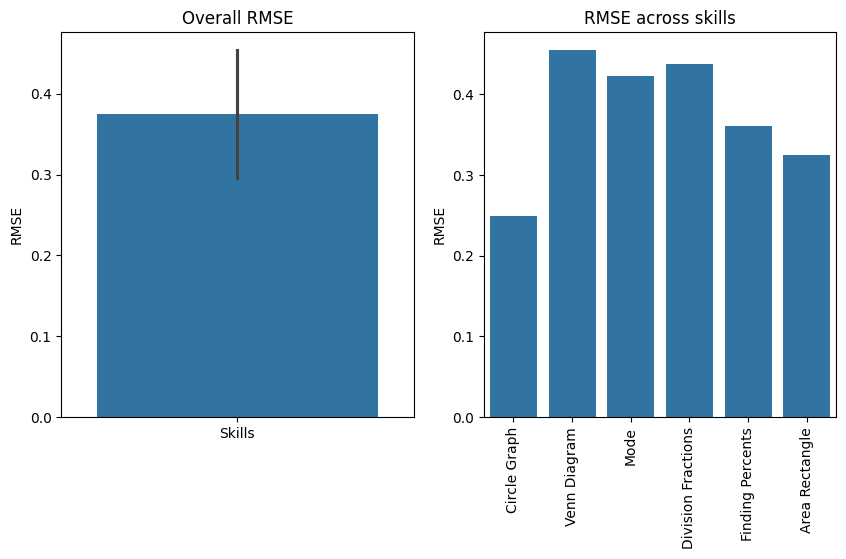

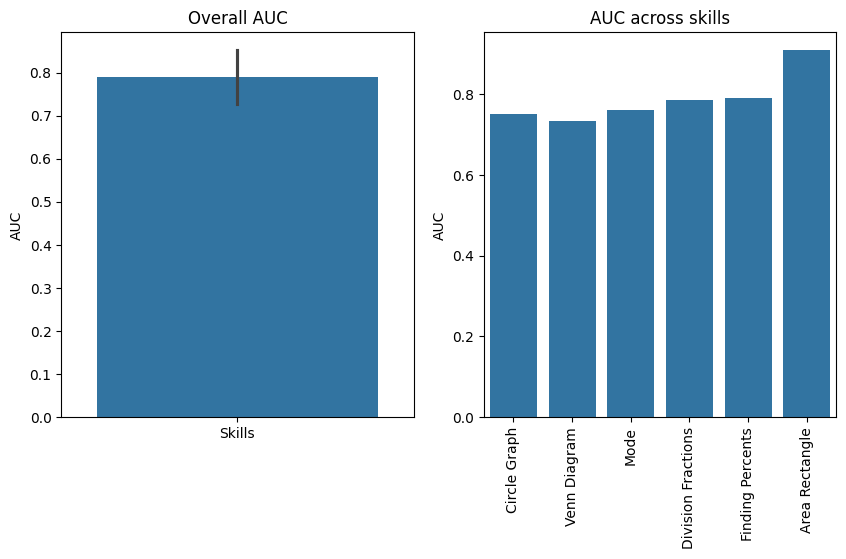

In [21]:
# Create overall RMSE and RMSE per skill data frames
skills_all = ['Skills']*len(skills_subset)
df_overall_rmse = pd.DataFrame(list(zip(skills_all, skill_rmse)),
               columns =['x', 'RMSE'])
df_skill_rmse = pd.DataFrame(list(zip(skills_subset, skill_rmse)),
               columns =['x', 'RMSE'])

# Create overall AUC and AUC per skill data frames
df_overall_auc = pd.DataFrame(list(zip(skills_all, skill_auc)),
               columns =['x', 'AUC'])
df_skill_auc = pd.DataFrame(list(zip(skills_subset, skill_auc)),
               columns =['x', 'AUC'])

# Two bar plots for RMSE: first one with std (mean RMSE over all skills), then one bar plot with a bar for each specific skill
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.barplot(ax=axes[0],x='x', y='RMSE', data=df_overall_rmse, estimator=np.mean, errorbar='sd')
axes[0].set_title('Overall RMSE')
axes[0].set_xlabel('')

sns.barplot(ax=axes[1],x='x', y='RMSE', data=df_skill_rmse, estimator=np.mean, errorbar='sd')
plt.xticks(rotation=90)
axes[1].set_title('RMSE across skills')
axes[1].set_xlabel('')

fig.show()

# Two bar plots for AUC: first one with std (mean AUC over all skills), then one bar plot with a bar for each specific skill
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.barplot(ax=axes[0],x='x', y='AUC', data=df_overall_auc, estimator=np.mean, errorbar='sd')
axes[0].set_title('Overall AUC')
axes[0].set_xlabel('')

sns.barplot(ax=axes[1],x='x', y='AUC', data=df_skill_auc, estimator=np.mean, errorbar='sd')
plt.xticks(rotation=90)
axes[1].set_title('AUC across skills')
axes[1].set_xlabel('')

fig.show()

Examining the RMSE across skills, we note that Venn Diagram has the largest RMSE, closely followed by division fractions and mode. The Circle Graph skills has the least RMSE (around 0.25) and is therefore most accurate. There is a large standard deviation across the average RMSE (top left plot), which indicates that the RMSE scores for BKT are skill-dependent.

We observe that the AUC is relatively high, on average ~78% across skills. Area Rectangle has a very high AUC while the other skills remain between the 75% to 80% range. The lack of variation between skills shows some indication that AUC is not as skill-dependent as RMSE (but this can only be confirmed by looking at a larger number of skills).